In [1]:
import re
import html
import pandas as pd
import spacy
from string import punctuation
from math import sqrt, ceil
# gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
# progress bars
from tqdm import tqdm
tqdm.pandas()

#### Import custom text preprocessing class for this exercise
For this dataset, the class `Textpreprocessor` is defined in the file `custom_preprocessing.py`.

In [2]:
from custom_preprocessing import TextPreprocessor

### Read in New York Times Dataset
A pre-processed version of the NYT news dataset is read in as a DataFrame.

In [3]:
data_path = "../data/nytimes.tsv"

df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['date', 'headline', 'content'])
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.head()

,date,headline,content
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...


#### (Optional) Subset the dataframe for testing
Test on a subset of the full data for quicker results.

In [4]:
df1 = df.iloc[:1000, :].copy()
# df1 = df.copy()

#### Include some extra words to remove from article text
Some unnecessary worsd show up in the article text that also need to be added to the default stopword list.

In [5]:
extra_words = ['-pron-', 'mr', 'mrs', 'ms', 'dr', 'million']
removed_words = set(punctuation).union(set(extra_words))

#### Call TextProcessor class
Clean up the text content for the topic model. Stopword removal and lemmatization are done as well. 

In [6]:
preproc = TextPreprocessor()
df1['lemmas'] = df1['content'].progress_apply(
                lambda text: preproc.lemmatize(text, removed_words)
                )
df1.head()

100%|██████████| 1000/1000 [00:07<00:00, 128.31it/s]


,date,headline,content,lemmas
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...,"[stellar, pitch, keep, mets, afloat, half, sea..."
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,"[mayor, bill, de, blasios, counsel, chief, leg..."
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,"[early, morning, hour, labor, day, year, group..."
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...,"[apple, store, new, york, city, thing, apple, ..."
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...,"[united, states, olympic, swim, trial, spectac..."


### Build LDA Model

#### Serial LDA algorithm

In [7]:
def run_lda(text_df, num_topics, iterations=200):
    id2word = corpora.Dictionary(text_df['lemmas'])
    # Filter out words that occur in less than 20 documents or more than 50% of the documents.
    id2word.filter_extremes(no_below=20, no_above=0.5)
    corpus = [id2word.doc2bow(text) for text in text_df['lemmas']]
    # LDA Model
    lda_model = LdaModel(
       corpus=corpus,
       id2word=id2word,
       num_topics=num_topics,
       alpha='auto',
       eta='auto',
       random_state=1,
       chunksize=2000,
       passes=10,
       iterations=iterations,
    )
    return lda_model

#### Multicore LDA algorithm

In [8]:
# Choose number of workers for multicore LDA as (num_physical_cores - 1)
def run_lda_multicore(text_df, num_topics, iterations=200, workers=3):
    id2word = corpora.Dictionary(text_df['lemmas'])
    # Filter out words that occur in less than 20 documents or more than 50% of the documents.
    id2word.filter_extremes(no_below=20, no_above=0.5)
    corpus = [id2word.doc2bow(text) for text in text_df['lemmas']]
    # LDA Model
    lda_model = LdaMulticore(
       corpus=corpus,
       id2word=id2word,
       workers=workers,
       num_topics=num_topics,
       random_state=1,
       chunksize=2000,
       passes=20,
       iterations=iterations,
    )
    return lda_model

### Wordclouds of most likely words in each topic

In [9]:
def plot_wordclouds(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    # Define the size of the subplot matrix as a function of num_topics  
    subplot_dim = ceil(sqrt(len(topics)))
    fig, axes = plt.subplots(subplot_dim, subplot_dim,
                             figsize=(15, 15), sharex=True, sharey=True);

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        try:
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words)
            plt.gca().imshow(cloud);
            plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16));
            plt.gca().axis('off');
        except IndexError:
            # If there aren't enough topics to fill a square subplot matrix,
            # return a blank plot with no axes
            plt.gca().axis('off');

    plt.subplots_adjust(wspace=0, hspace=0);
    plt.axis('off');
    plt.margins(x=0, y=0);
    plt.tight_layout();

### Run topic model and plot wordclouds

In [10]:
num_topics = 9
iterations = 200

model = run_lda_multicore(df1, num_topics=num_topics, iterations=iterations)

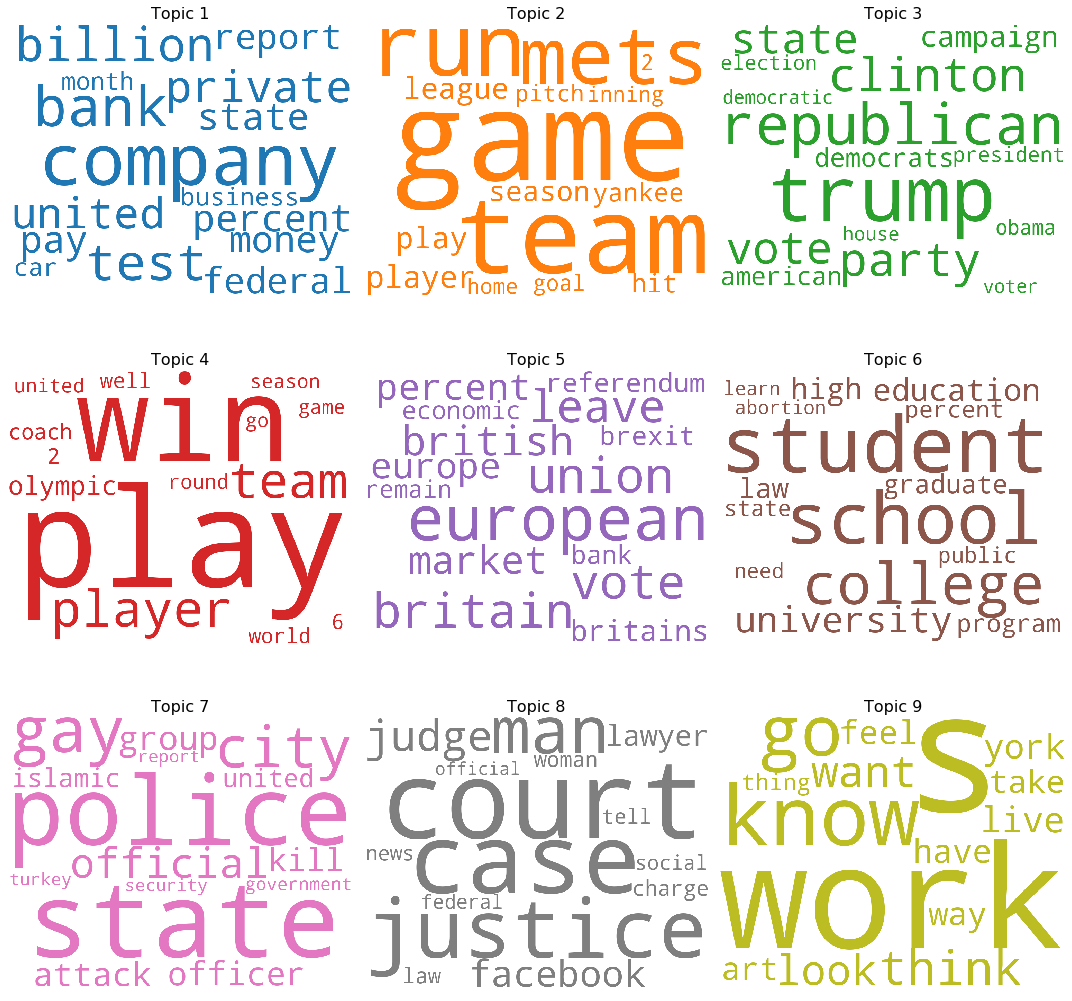

In [13]:
plot_wordclouds(model.show_topics(formatted=False, num_topics=num_topics, num_words=15))